Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.losses import MeanSquaredLogarithmicError
from keras.models import load_model
import ast
# from keras.preprocessing.sequence import pad_sequences

Mounted at /content/drive


# Tensorflow Model Architecture (100m only)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_100m.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})



df

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 5111,Descriptors 5112,Descriptors 5113,Descriptors 5114,Descriptors 5115,Descriptors 5116,Descriptors 5117,Descriptors 5118,Descriptors 5119,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2769,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,18.0,15.0,7.0,9.0,0.0,0.0,41.22
2770,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
2771,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22
2772,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [3]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df[df['Feature Extraction 0'].isna()]
nan_rows_d = df[df['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df = df.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df = df.dropna(subset=['Descriptors 0'])

Found 1387 rows with NaN values in the Feature Extraction column.
Found 1387 rows with NaN values in the Descriptors column.


In [4]:

X = df.drop('Carbon Values', axis=1)
y = df['Carbon Values']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values
y_test = y_test.values

In [7]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MaxAbsScaler

# Flatten the input sequences
X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])

# Normalize the flattened sequences
scaler = MaxAbsScaler()

X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)


X_train_padded = np.expand_dims(X_train_normalized, axis=-1)
X_test_padded = np.expand_dims(X_test_normalized, axis=-1)


In [8]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling1D()(x)


x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)

model = Model(inputs=inputs, outputs=outputs)


Model Parameters

In [9]:
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

Model Training

In [10]:
hist = model.fit(X_train_padded, y_train, 
                 epochs= 300, 
                 batch_size=64,
                verbose = 1, 
                callbacks=[reduce_lr,early_stop], 
                validation_data = (X_test_padded, y_test))

Epoch 1/300
18/18 [==============================] - 10s 85ms/step - loss: 35.2034 - val_loss: 99.4443 - lr: 0.0010
Epoch 2/300
18/18 [==============================] - 1s 50ms/step - loss: 26.7995 - val_loss: 99.5740 - lr: 0.0010
Epoch 3/300
18/18 [==============================] - 1s 64ms/step - loss: 23.0255 - val_loss: 99.8191 - lr: 0.0010
Epoch 4/300
18/18 [==============================] - 1s 65ms/step - loss: 22.7841 - val_loss: 99.9825 - lr: 0.0010
Epoch 5/300
18/18 [==============================] - 1s 77ms/step - loss: 22.0109 - val_loss: 100.1036 - lr: 0.0010
Epoch 6/300
18/18 [==============================] - 1s 68ms/step - loss: 20.5616 - val_loss: 100.1176 - lr: 0.0010
Epoch 7/300
18/18 [==============================] - 1s 71ms/step - loss: 20.9064 - val_loss: 100.0145 - lr: 0.0010
Epoch 8/300
18/18 [==============================] - 1s 67ms/step - loss: 21.4648 - val_loss: 99.9460 - lr: 0.0010
Epoch 9/300
18/18 [==============================] - 1s 66ms/step - loss: 23

Evaluate Model

In [ ]:
# keras_model_1 = load_model('/content/drive/MyDrive/Skripsi/model/model_fast_FIX.h5')

In [11]:
# Evaluate the model
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test_padded)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

9/9 [==============================] - 0s 7ms/step
MAPE: 0.14261643897005968


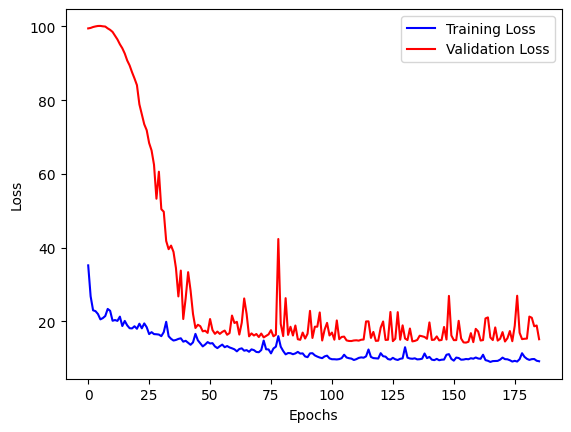

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Displaying the plot
plt.show()

plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)




R-squared score on test set: 0.34586881233934164
Mean Absolute Error (MAE): 4.289930976483462
Root Mean Squared Error (RMSE): 6.894622175142531


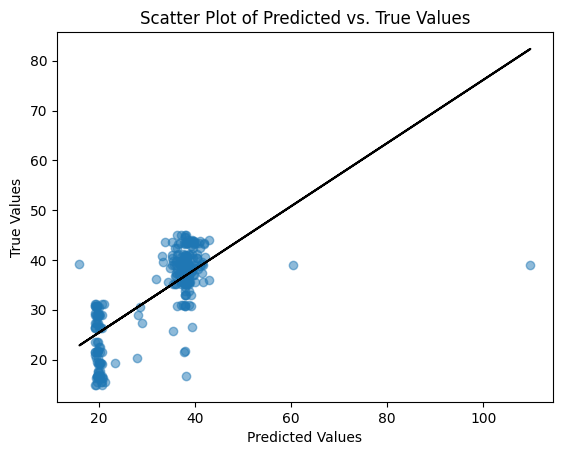

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred.flatten(), y_test.flatten(), 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [17]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test)
print("Model score:", score)


[LibSVM]Model score: 0.45887833408662126


In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.45887833408662126
Mean Absolute Error (MAE): 5.016987580602308
Root Mean Squared Error (RMSE): 6.27083690203087
Mean Absolute Percentage Error (MAPE): 0.17458047847689923


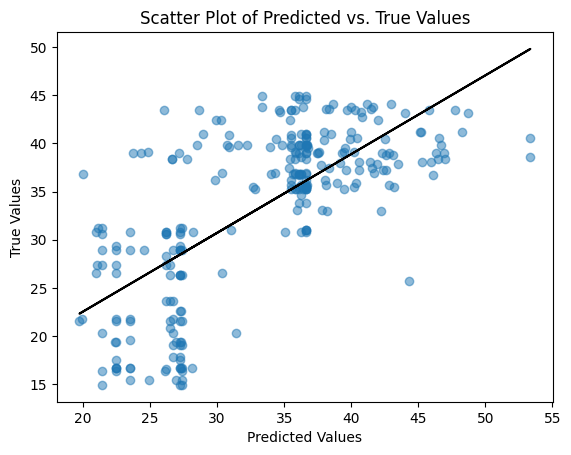

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [20]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test, y_pred)
print("Model score:", score)


Model score: 0.7354234124622656


In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7354234124622656
Mean Absolute Error (MAE): 3.5698106777645364
Root Mean Squared Error (RMSE): 4.384839983682271
Mean Absolute Percentage Error (MAPE): 0.12726671976767537


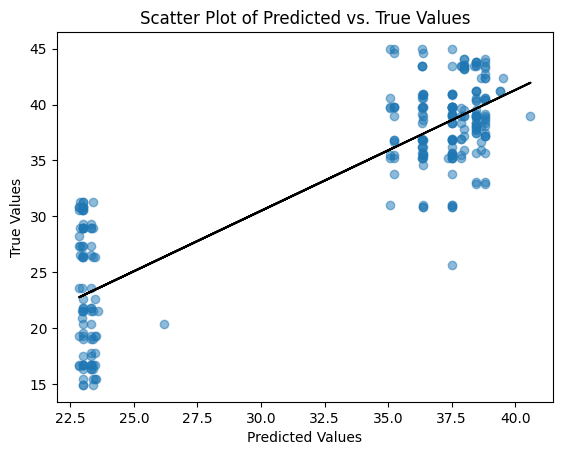

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [23]:
model_filename = 'model_sift_cobalagi.h5'

model.save('/content/drive/MyDrive/Skripsi/model/'+ model_filename)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import pickle
# filename = 'finalized_model_svr.sav'
# file_path = '/content/drive/MyDrive/Skripsi/model/' + filename

# # Save the model using pickle
# with open(file_path, 'wb') as file:
#     pickle.dump(model_svr, file)

# print(f"Model saved to {file_path}")

Model saved to /content/drive/MyDrive/Skripsi/model/finalized_model_svr.sav


# Tensorflow Model Architecture (50m only)

In [24]:
df = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_50m.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 6135,Descriptors 6136,Descriptors 6137,Descriptors 6138,Descriptors 6139,Descriptors 6140,Descriptors 6141,Descriptors 6142,Descriptors 6143,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43.0,115.0,52.0,9.0,9.0,3.0,4.0,9.0,34.0,41.22
2576,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,41.22
2577,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,40.0,9.0,8.0,9.0,9.0,12.0,62.0,131.0,41.22
2578,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,101.0,2.0,0.0,0.0,0.0,0.0,5.0,13.0,5.0,41.22


In [25]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df[df['Feature Extraction 0'].isna()]
nan_rows_d = df[df['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df = df.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df = df.dropna(subset=['Descriptors 0'])

Found 1290 rows with NaN values in the Feature Extraction column.
Found 1290 rows with NaN values in the Descriptors column.


In [26]:

X = df.drop('Carbon Values', axis=1)
y = df['Carbon Values']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values
y_test = y_test.values

In [29]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train, X_test])

# Flatten the input sequences
X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)

# Reshape the padded sequences to match the input shape expected by the model
X_train_padded = np.expand_dims(X_train_normalized, axis=-1)
X_test_padded = np.expand_dims(X_test_normalized, axis=-1)


In [ ]:
print(X_train_flattened )
print(X_train_normalized)

[[2. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]]
[[1.  0.  0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.  ... 0.  0.  0. ]
 ...
 [0.5 0.  0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]]


In [30]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

# Add the layers with pooling and dropout
x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling1D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)

model = Model(inputs=inputs, outputs=outputs)


Model Parameters

In [31]:
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

Model Training

In [32]:
hist = model.fit(X_train_padded, y_train, epochs= 300, batch_size=64, verbose = 1, callbacks=[reduce_lr,early_stop], validation_data = (X_test_padded, y_test))

Epoch 1/300
17/17 [==============================] - 5s 96ms/step - loss: 41.4462 - val_loss: 99.3034 - lr: 0.0010
Epoch 2/300
17/17 [==============================] - 1s 66ms/step - loss: 28.6457 - val_loss: 99.4965 - lr: 0.0010
Epoch 3/300
17/17 [==============================] - 1s 61ms/step - loss: 26.0502 - val_loss: 99.5071 - lr: 0.0010
Epoch 4/300
17/17 [==============================] - 1s 69ms/step - loss: 26.0853 - val_loss: 99.5833 - lr: 0.0010
Epoch 5/300
17/17 [==============================] - 1s 69ms/step - loss: 25.0406 - val_loss: 99.5549 - lr: 0.0010
Epoch 6/300
17/17 [==============================] - 1s 69ms/step - loss: 23.7447 - val_loss: 99.3910 - lr: 0.0010
Epoch 7/300
17/17 [==============================] - 1s 68ms/step - loss: 23.1315 - val_loss: 99.1645 - lr: 0.0010
Epoch 8/300
17/17 [==============================] - 1s 61ms/step - loss: 22.9751 - val_loss: 98.8620 - lr: 0.0010
Epoch 9/300
17/17 [==============================] - 1s 66ms/step - loss: 22.127

Evaluate Model

In [ ]:
# keras_model_1 = load_model('/content/drive/MyDrive/Skripsi/model/model_fast_FIX.h5')

In [33]:
# Evaluate the model
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test_padded)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

9/9 [==============================] - 0s 8ms/step
MAPE: 0.227073456893386


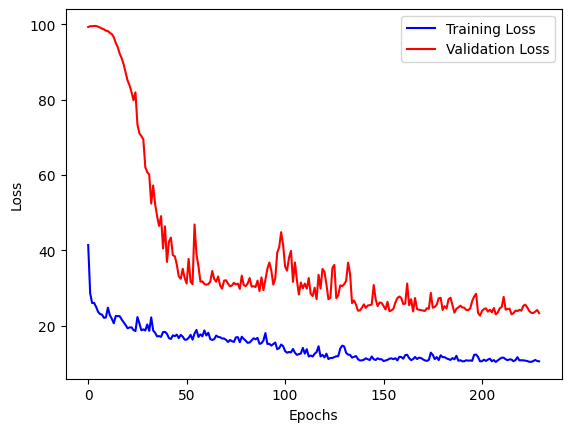

In [34]:
plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)




R-squared score on test set: -18.643267561264324
Mean Absolute Error (MAE): 7.02291807278182
Root Mean Squared Error (RMSE): 36.95246274704005


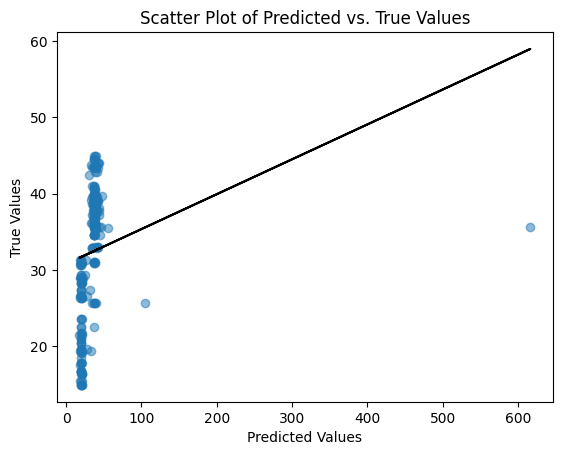

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred.flatten(), y_test.flatten(), 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [38]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test)
print("Model score:", score)


[LibSVM]Model score: 0.5302036805843584


In [39]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5302036805843584
Mean Absolute Error (MAE): 4.6934264020241026
Root Mean Squared Error (RMSE): 5.714672238256526
Mean Absolute Percentage Error (MAPE): 0.17320877612565452


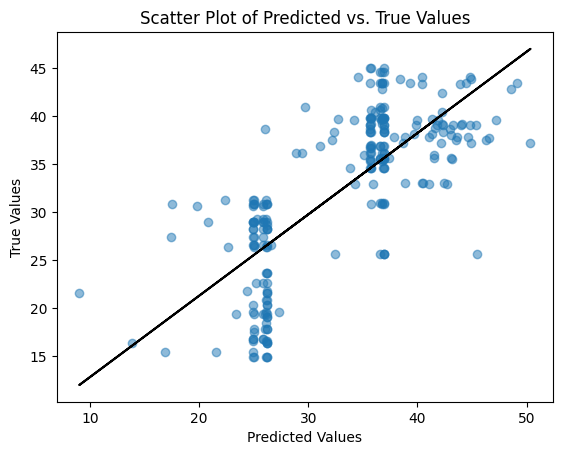

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [41]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test, y_pred)
print("Model score:", score)


Model score: 0.6739741001334416


In [42]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6739741001334416
Mean Absolute Error (MAE): 3.876006279371351
Root Mean Squared Error (RMSE): 4.7606096528803015
Mean Absolute Percentage Error (MAPE): 0.14244812965245368


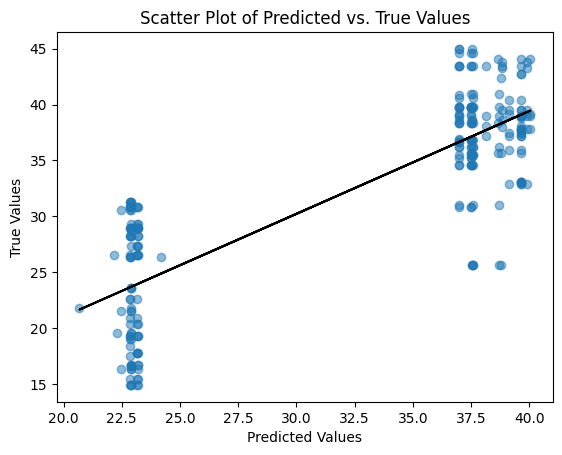

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# Tensorflow Model Architecture (25m only)

In [57]:
df = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_25m.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 5495,Descriptors 5496,Descriptors 5497,Descriptors 5498,Descriptors 5499,Descriptors 5500,Descriptors 5501,Descriptors 5502,Descriptors 5503,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,0.0,5.0,2.0,0.0,37.46
1942,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.46
1943,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,47.0,79.0,23.0,10.0,3.0,13.0,22.0,23.0,37.46
1944,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [58]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df[df['Feature Extraction 0'].isna()]
nan_rows_d = df[df['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df = df.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df = df.dropna(subset=['Descriptors 0'])

Found 973 rows with NaN values in the Feature Extraction column.
Found 973 rows with NaN values in the Descriptors column.


In [59]:

X = df.drop('Carbon Values', axis=1)
y = df['Carbon Values']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = y_train.values
y_test = y_test.values

In [62]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train, X_test])

# Flatten the input sequences
X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flattened)
X_test_normalized = scaler.transform(X_test_flattened)

# Determine the maximum sequence length in the entire dataset
# Reshape the padded sequences to match the input shape expected by the model
X_train_padded = np.expand_dims(X_train_normalized, axis=-1)
X_test_padded = np.expand_dims(X_test_normalized, axis=-1)


In [ ]:
print(X_train_flattened )
print(X_train_normalized)

[[2. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]]
[[1.  0.  0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.  ... 0.  0.  0. ]
 ...
 [0.5 0.  0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]]


In [63]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

# Add the layers with pooling and dropout
x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling1D()(x)

x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)

model = Model(inputs=inputs, outputs=outputs)


Model Parameters

In [64]:
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

Model Training

In [65]:
hist = model.fit(X_train_padded, y_train, epochs= 300, batch_size=64, verbose = 1, callbacks=[reduce_lr,early_stop], validation_data = (X_test_padded, y_test))

Epoch 1/300
13/13 [==============================] - 6s 82ms/step - loss: 39.3078 - val_loss: 98.5392 - lr: 0.0010
Epoch 2/300
13/13 [==============================] - 1s 56ms/step - loss: 23.5193 - val_loss: 98.5780 - lr: 0.0010
Epoch 3/300
13/13 [==============================] - 1s 58ms/step - loss: 20.1181 - val_loss: 98.7439 - lr: 0.0010
Epoch 4/300
13/13 [==============================] - 1s 58ms/step - loss: 22.8572 - val_loss: 98.7164 - lr: 0.0010
Epoch 5/300
13/13 [==============================] - 1s 56ms/step - loss: 18.8413 - val_loss: 99.2222 - lr: 0.0010
Epoch 6/300
13/13 [==============================] - 1s 56ms/step - loss: 17.3517 - val_loss: 99.5823 - lr: 0.0010
Epoch 7/300
13/13 [==============================] - 1s 57ms/step - loss: 21.6194 - val_loss: 99.8498 - lr: 0.0010
Epoch 8/300
13/13 [==============================] - 1s 56ms/step - loss: 16.8015 - val_loss: 100.1126 - lr: 0.0010
Epoch 9/300
13/13 [==============================] - 1s 58ms/step - loss: 15.54

Evaluate Model

In [ ]:
# keras_model_1 = load_model('/content/drive/MyDrive/Skripsi/model/model_fast_FIX.h5')

In [66]:
# Evaluate the model
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test_padded)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

7/7 [==============================] - 0s 11ms/step
MAPE: 0.5938879684582848


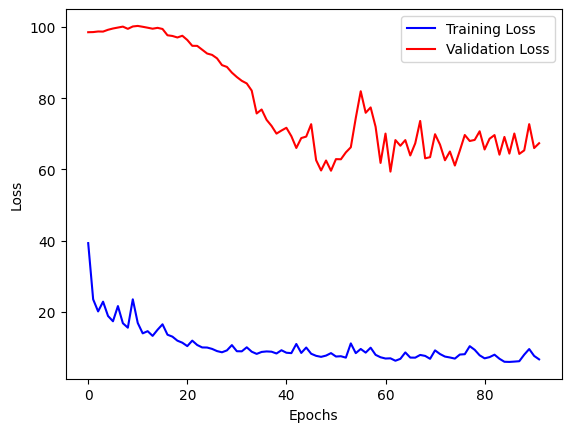

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='Training Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [68]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)




R-squared score on test set: -446.28123196578156
Mean Absolute Error (MAE): 21.881351534329923
Root Mean Squared Error (RMSE): 162.2323547955009


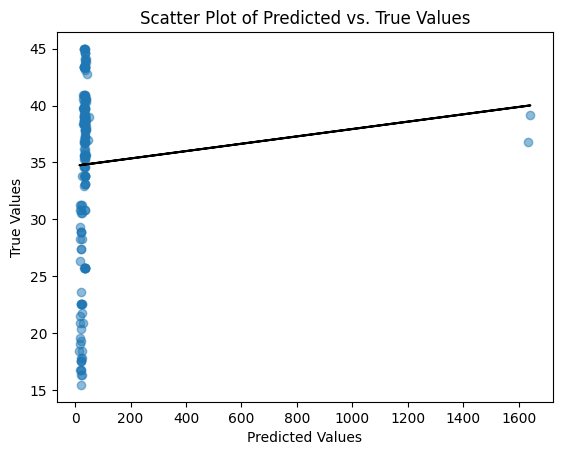

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred.flatten(), y_test.flatten(), 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


SVR 25m

In [71]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test)
print("Model score:", score)


[LibSVM]Model score: 0.5145562247364431


In [72]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5145562247364431
Mean Absolute Error (MAE): 4.256559501191498
Root Mean Squared Error (RMSE): 5.344617170307198
Mean Absolute Percentage Error (MAPE): 0.14364230984490003


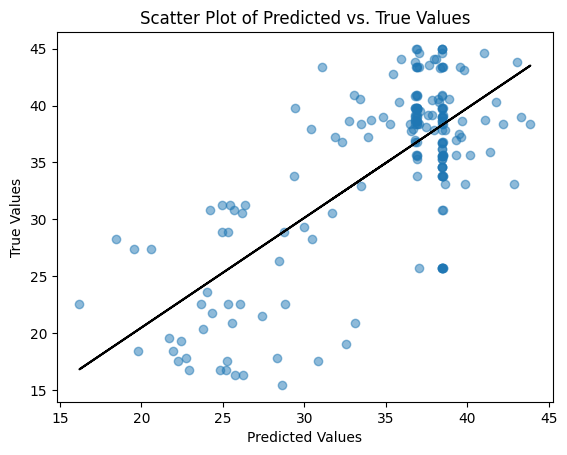

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [74]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test, y_pred)
print("Model score:", score)


Model score: 0.6186138147893979


In [75]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6186138147893979
Mean Absolute Error (MAE): 3.6762388886253583
Root Mean Squared Error (RMSE): 4.7372860909556715
Mean Absolute Percentage Error (MAPE): 0.12026900813701485


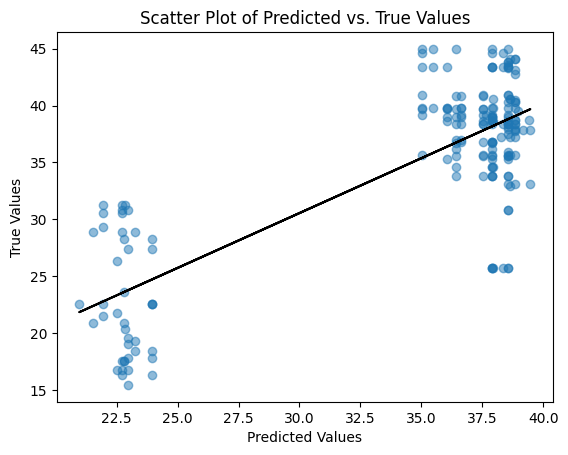

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()
